# Download Air Traffic Data and Import Basic Pkgs

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import ipdb

# Load Data

## OD data

In [2]:
# generate an OD matrix from cumulative trip record
# completed by code "OD_batch.py"

In [3]:
year = 2019
quarter = 4

OD = pd.read_csv('./outputs/%i0%i_OD.csv'%(year, quarter), index_col=0)


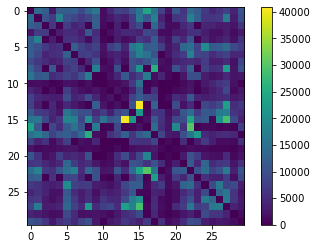

In [4]:
plt.figure()
plt.imshow(OD)
plt.colorbar()

## SLD

In [5]:
# metadata = pd.read_csv('./data/US-APT-Information.csv', index_col=0)
# metadata.head(2)

airport_df = pd.read_csv('./data/airport_core.csv')
airport_df = airport_df.sort_values(by='city')
airport_df.head(2)

,Airport,lat,lon,state,state_code,city
0,ATL,33.640833,-84.427222,Georgia,GA,Atlanta
1,BOS,42.363611,-71.006111,Massachusetts,MA,Boston


In [6]:
sl_data = pd.read_csv('./data/Smart Location Data Export.csv')
sl_data['GEOID'] = sl_data['GEOID20'] // 10
sl_data['COUNTYID'] = sl_data['GEOID20'] // 1e7

In [7]:
sl_data.head(2)

,OBJECTID,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CSA,CSA_Name,CBSA,...,VMT_tot_min,VMT_tot_max,VMT_tot_avg,GHG_per_worker,Annual_GHG,SLC_score,Shape_Length,Shape_Area,GEOID,COUNTYID
0,1,481130078254,481130078254,48,113,7825,4,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,11.442995,82.636303,25.659327,24.499297,6369.817221,77.450956,3110.36082,297836.0831,48113007825,48113.0
1,2,481130078252,481130078252,48,113,7825,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,11.442995,82.636303,25.659327,23.580987,6131.056669,78.898635,3519.46911,484945.1466,48113007825,48113.0


In [8]:
# may spend around 2 minutes
us_tract = gpd.GeoDataFrame(columns=['GEOID', 'geometry', 'INTPTLAT', 'INTPTLON'])
for i in ['01','04','05','06','08','09',10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56]:
    try:
        tract = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_%i_tract.zip'%i)[['GEOID', 'geometry', 'INTPTLAT', 'INTPTLON']]
    except:
        tract = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_%s_tract.zip'%i)[['GEOID', 'geometry', 'INTPTLAT', 'INTPTLON']]
    us_tract = us_tract.append(tract)

us_tract.index = range(us_tract.shape[0])


In [9]:
def add_att(df, att, type_):
    # type_ can be 'sum', 'mean' or 'same'
    df[att] = ''
    for i in df.index:
        geoid = int(df.loc[i, 'GEOID'])
        if type_ == 'sum':
            df.loc[i, att] = sl_data.loc[sl_data['GEOID']==geoid, att].sum()
        elif type_ == 'mean':
            df.loc[i, att] = sl_data.loc[sl_data['GEOID']==geoid, att].mean()
        elif type_ == 'same':
#             ipdb.set_trace()
            df.loc[i, att] = sl_data.loc[sl_data['GEOID']==geoid, att].iloc[0]
    return df
    

In [34]:
att_lst = [
    'STATEFP', 'CSA', 'CSA_Name', 'CBSA', 'CBSA_Name', 'AutoOwn0', 'AutoOwn1', 'AutoOwn2p',\
    'TotEmp', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', 'D1B', 'D1C', 'D3A', 'D4A', 'D4B050', 'D4C', 'D4D', \
    'D5AR', 'D5AE', 'NatWalkInd', 'TotPop'
]

type_lst = [
    'same', 'same', 'same', 'same', 'same', 'sum', 'sum', 'sum',\
    'sum', 'sum', 'sum', 'sum', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean',\
    'sum', 'sum', 'mean', 'sum'
]

assert(len(att_lst) == len(type_lst))

In [11]:
# may spend around 20~30 minutes
for i in range(len(att_lst)):
    us_tract = add_att(us_tract, att_lst[i], type_lst[i])
    print('Complete', att_lst[i])

Complete CSA
Complete CSA_Name
Complete CBSA
Complete CBSA_Name
Complete AutoOwn0
Complete AutoOwn1
Complete AutoOwn2p
Complete TotEmp
Complete E_LowWageWk
Complete E_MedWageWk
Complete E_HiWageWk
Complete D1B
Complete D1C
Complete D3A
Complete D4A
Complete D4B050
Complete D4C
Complete D4D
Complete D5AR
Complete D5AE
Complete NatWalkInd
Complete TotPop


In [35]:
# may spend around 2 minutes
for i in us_tract.index:
    us_tract.loc[i, 'COUNTYID'] = us_tract.loc[i, 'GEOID'][:5]

att_lst.extend(['COUNTYID', 'GEOID', 'INTPTLAT', 'INTPTLON'])
type_lst.extend(['same', 'same', 'mean', 'mean'])


In [75]:
us_tract[['INTPTLAT', 'INTPTLON']] = us_tract[['INTPTLAT', 'INTPTLON']].astype(float)
us_tract.head(2)

,GEOID,geometry,INTPTLAT,INTPTLON,STATEFP,CSA,CSA_Name,CBSA,CBSA_Name,AutoOwn0,...,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,TotPop,COUNTYID
0,01055010700,"POLYGON ((-85.98699 34.04413, -85.98606 34.045...",34.072660,-85.899194,1,NaN,NaN,23460.0,"Gadsden, AL",69,...,3.610139,-99999.0,0.0,-99999.0,-99999.0,13684,13141,4.166667,3750,01055
1,01055001300,"POLYGON ((-86.00068 34.00537, -86.00023 34.006...",34.007878,-85.986595,1,NaN,NaN,23460.0,"Gadsden, AL",136,...,16.467295,-99999.0,0.0,-99999.0,-99999.0,54622,43352,8.666667,2807,01055


In [76]:
from shapely.ops import unary_union

def get_county_data():
    # 新建一个表格，找出各个county的数据（通过合并各个county的tract来实现）
    county_lst = us_tract['COUNTYID'].drop_duplicates()  # datatype: series
    col_ = ['TotPop', 'COUNTYID', 'geometry']
    county_data = gpd.GeoDataFrame(columns=col_, index=range(len(county_lst)))
    
    for i in range(len(county_lst)):
        this_county_id = county_lst.iloc[i]
        this_county = us_tract[us_tract['COUNTYID']==this_county_id]
        polygons = this_county['geometry']
        boundary = gpd.GeoSeries(unary_union(polygons))
        
        county_data.loc[i, 'geometry'] = boundary.values
        county_data.loc[i, 'COUNTYID'] = this_county_id
        county_data.loc[i, 'TotPop'] = this_county['TotPop'].sum()
        
    return county_data

In [77]:
# may spend around 1.5 minutes
us_county = get_county_data()

In [78]:
us_county.head(2)

,TotPop,COUNTYID,geometry
0,102939,01055,"POLYGON ((-85.98820 33.87924, -85.99497 33.879..."
1,20298,01107,"POLYGON ((-88.33929 33.00300, -88.33845 33.010..."


In [79]:
def add_att_county(df, att, type_):
    # type_ can be 'sum', 'mean' or 'same'
    df[att] = ''
    for i in df.index:
        geoid = int(df.loc[i, 'COUNTYID'])
        if type_ == 'sum':
            df.loc[i, att] = sl_data.loc[sl_data['COUNTYID']==geoid, att].sum()
        elif att == 'INTPTLAT' or att == 'INTPTLON':
            geoid_str = str(geoid)
            if len(geoid_str)!=5:
                geoid_str = '0' + geoid_str
            df.loc[i, att] = us_tract.loc[us_tract['COUNTYID']==geoid_str, att].mean()
        elif type_ == 'mean':
            df.loc[i, att] = sl_data.loc[sl_data['COUNTYID']==geoid, att].mean()
        elif type_ == 'same':
#             ipdb.set_trace()
            df.loc[i, att] = sl_data.loc[sl_data['COUNTYID']==geoid, att].iloc[0]
    return df


In [80]:
for i in range(len(att_lst)):
    # except for COUNTYID and GEOID
    if att_lst[i]=='COUNTYID' or att_lst[i]=='GEOID':
        continue
    us_county = add_att_county(us_county, att_lst[i], type_lst[i])
    print('Complete', att_lst[i])

Complete CSA
Complete CSA_Name
Complete CBSA
Complete CBSA_Name
Complete AutoOwn0
Complete AutoOwn1
Complete AutoOwn2p
Complete TotEmp
Complete E_LowWageWk
Complete E_MedWageWk
Complete E_HiWageWk
Complete D1B
Complete D1C
Complete D3A
Complete D4A
Complete D4B050
Complete D4C
Complete D4D
Complete D5AR
Complete D5AE
Complete NatWalkInd
Complete TotPop
Complete INTPTLAT
Complete INTPTLON


In [81]:
us_county.head(2)

,TotPop,COUNTYID,geometry,CSA,CSA_Name,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,...,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON
0,102939,01055,"POLYGON ((-85.98820 33.87924, -85.99497 33.879...",NaN,NaN,23460.0,"Gadsden, AL",2441,12009,24327,...,10.617419,-99999.0,0.0,-99999.0,-99999.0,1028152,900253,6.238956,34.020991,-86.020571
1,20298,01107,"POLYGON ((-88.33929 33.00300, -88.33845 33.010...",NaN,NaN,46220.0,"Tuscaloosa, AL",731,2298,4501,...,1.801684,-99999.0,0.0,-99999.0,-99999.0,36617,40661,4.54386,33.339703,-88.079808


In [83]:
from shapely.ops import unary_union

def get_state_data():
    # 新建一个表格，找出各个state的数据（通过合并各个state的tract来实现）
    state_lst = us_tract['STATEFP'].drop_duplicates()  # datatype: series
    col_ = ['TotPop', 'STATEFP', 'geometry']
    state_data = gpd.GeoDataFrame(columns=col_, index=range(len(state_lst)))
    
    for i in range(len(state_lst)):
        this_state_id = state_lst.iloc[i]
        this_state = us_tract[us_tract['STATEFP']==this_state_id]
        polygons = this_state['geometry']
        boundary = gpd.GeoSeries(unary_union(polygons))
        
        state_data.loc[i, 'geometry'] = boundary.values
        state_data.loc[i, 'STATEFP'] = this_state_id
        state_data.loc[i, 'TotPop'] = this_state['TotPop'].sum()
        
    return state_data

In [84]:
us_state = get_state_data()

In [87]:
def add_att_state(df, att, type_):
    # type_ can be 'sum', 'mean' or 'same'
    if att=='STATEFP':
        return df
    df[att] = ''
    for i in df.index:
        geoid = int(df.loc[i, 'STATEFP'])
        if type_ == 'sum':
            df.loc[i, att] = sl_data.loc[sl_data['STATEFP']==geoid, att].sum()
        elif att == 'INTPTLAT' or att == 'INTPTLON':
            df.loc[i, att] = us_tract.loc[us_tract['STATEFP']==geoid, att].mean()
        elif type_ == 'mean':
            df.loc[i, att] = sl_data.loc[sl_data['STATEFP']==geoid, att].mean()
        elif type_ == 'same':
#             ipdb.set_trace()
            df.loc[i, att] = sl_data.loc[sl_data['STATEFP']==geoid, att].iloc[0]
    return df
    

In [88]:
for i in range(len(att_lst)):
    # except for COUNTYID and GEOID
    if att_lst[i]=='COUNTYID' or att_lst[i]=='GEOID':
        continue
    us_state = add_att_state(us_state, att_lst[i], type_lst[i])
    print('Complete', att_lst[i])

Complete CSA
Complete CSA_Name
Complete CBSA
Complete CBSA_Name
Complete AutoOwn0
Complete AutoOwn1
Complete AutoOwn2p
Complete TotEmp
Complete E_LowWageWk
Complete E_MedWageWk
Complete E_HiWageWk
Complete D1B
Complete D1C
Complete D3A
Complete D4A
Complete D4B050
Complete D4C
Complete D4D
Complete D5AR
Complete D5AE
Complete NatWalkInd
Complete TotPop
Complete INTPTLAT
Complete INTPTLON


In [89]:
us_state.head(2)

,TotPop,STATEFP,geometry,CSA,CSA_Name,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,...,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON
0,4864680,1,"POLYGON ((-88.06069 30.14442, -88.06919 30.146...",142.0,"Birmingham-Hoover-Talladega, AL",13820.0,"Birmingham-Hoover, AL",115360,602858,1142051,...,9.141649,-85691.056591,0.0,-85891.734212,-85890.980826,80015382,58768634,6.8312,32.937699,-86.770341
1,6946685,4,"POLYGON ((-112.62491 31.82102, -112.62548 31.8...",429.0,"Phoenix-Mesa, AZ",38060.0,"Phoenix-Mesa-Chandler, AZ",160011,912818,1451471,...,17.872108,-45943.701668,0.026742,-39583.881192,-39569.96112,285956773,225138695,10.104197,33.349931,-111.866664


In [90]:
from shapely.ops import unary_union

def get_CBSA_data():
    # 新建一个表格，找出各个 CBSA 的数据（通过合并各个 CBSA 来实现）
    CBSA_lst = us_tract['CBSA'].drop_duplicates()  # datatype: series
    col_ = ['TotPop', 'CBSA', 'geometry']
    CBSA_data = gpd.GeoDataFrame(columns=col_, index=range(len(CBSA_lst)))
    
    for i in range(len(CBSA_lst)):
        this_CBSA_id = CBSA_lst.iloc[i]
        this_state = us_tract[us_tract['CBSA']==this_CBSA_id]
        polygons = this_state['geometry']
        boundary = gpd.GeoSeries(unary_union(polygons))
        
        CBSA_data.loc[i, 'geometry'] = boundary.values
        CBSA_data.loc[i, 'CBSA'] = this_CBSA_id
        CBSA_data.loc[i, 'TotPop'] = this_state['TotPop'].sum()
        
    return CBSA_data

In [91]:
us_CBSA = get_CBSA_data()

In [94]:
us_CBSA.head(2)

,TotPop,CBSA,geometry,CSA
0,102939,23460.0,"POLYGON ((-85.98820 33.87924, -85.99497 33.879...",NaN
1,249824,46220.0,"POLYGON ((-87.52531 32.60098, -87.52531 32.600...",NaN


In [96]:
def add_att_CBSA(df, att, type_):
    # type_ can be 'sum', 'mean' or 'same'
    if att=='CBSA' or att=='CBSA_Name':
        return df
    df[att] = ''
    for i in df.index:
        try:
            geoid = int(df.loc[i, 'CBSA'])
        except:
            continue
        if type_ == 'sum':
            df.loc[i, att] = sl_data.loc[sl_data['CBSA']==geoid, att].sum()
        elif att == 'INTPTLAT' or att == 'INTPTLON':
            df.loc[i, att] = us_tract.loc[us_tract['CBSA']==geoid, att].mean()
        elif type_ == 'mean':
            df.loc[i, att] = sl_data.loc[sl_data['CBSA']==geoid, att].mean()
        elif type_ == 'same':
#             ipdb.set_trace()
            df.loc[i, att] = sl_data.loc[sl_data['CBSA']==geoid, att].iloc[0]
    return df
    

In [97]:
for i in range(len(att_lst)):
    # except for COUNTYID and GEOID
    if att_lst[i]=='COUNTYID' or att_lst[i]=='GEOID':
        continue
    us_CBSA = add_att_CBSA(us_CBSA, att_lst[i], type_lst[i])
    print('Complete', att_lst[i])

Complete CSA
Complete CSA_Name
Complete CBSA
Complete CBSA_Name
Complete AutoOwn0
Complete AutoOwn1
Complete AutoOwn2p
Complete TotEmp
Complete E_LowWageWk
Complete E_MedWageWk
Complete E_HiWageWk
Complete D1B
Complete D1C
Complete D3A
Complete D4A
Complete D4B050
Complete D4C
Complete D4D
Complete D5AR
Complete D5AE
Complete NatWalkInd
Complete TotPop
Complete INTPTLAT
Complete INTPTLON


In [98]:
us_CBSA.head(2)

,TotPop,CBSA,geometry,CSA,CSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageWk,...,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON
0,102939,23460.0,"POLYGON ((-85.98820 33.87924, -85.99497 33.879...",NaN,NaN,2441,12009,24327,37431,10413,...,10.617419,-99999.0,0.0,-99999.0,-99999.0,1028152,900253,6.238956,34.020991,-86.020571
1,249824,46220.0,"POLYGON ((-87.52531 32.60098, -87.52531 32.600...",NaN,NaN,6043,29777,52702,100155,25725,...,8.595404,-99999.0,0.0,-99999.0,-99999.0,2444455,1877340,6.16879,33.161686,-87.607731


<AxesSubplot:>

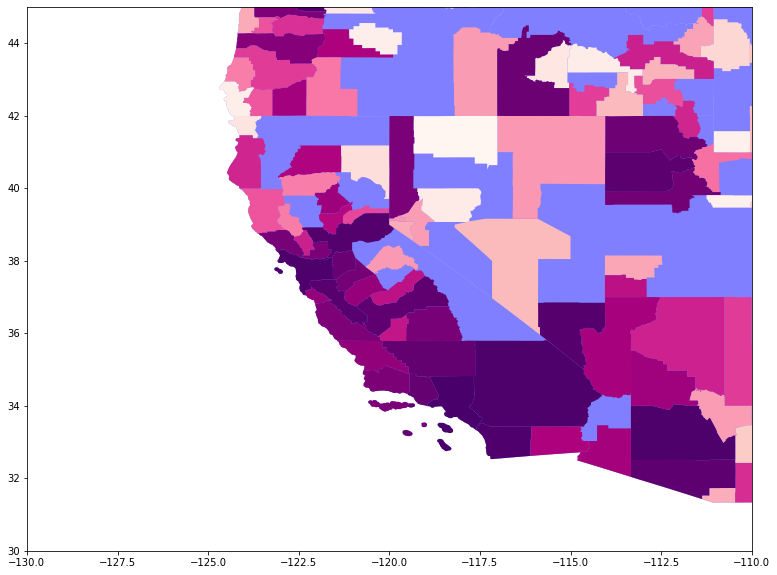

In [99]:
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(111)
ax.set_xlim([-130, -110])
ax.set_ylim([30, 45])
us_state.plot(ax=ax, color='b', alpha=0.5)
us_CBSA.plot(ax=ax, alpha=1, column='TotPop', cmap='RdPu')

In [115]:
# us_tract.fillna(0).to_file('./data/us_tract.shp', driver='ESRI Shapefile')
# us_county.fillna(0).to_file('./data/us_county.shp', driver='ESRI Shapefile')
# us_CBSA = us_CBSA.loc[us_CBSA['TotPop']!='']
# us_CBSA.fillna(0).to_file('./data/us_CBSA.shp', driver='ESRI Shapefile')
# us_state.fillna(0).to_file('./data/us_state.shp', driver='ESRI Shapefile')

# 找出各个机场的catchment area（county/city）

In [28]:
city_lst = list(sl_data['CBSA_Name'].drop_duplicates().dropna().values)

In [51]:
airport_df['CBSA_Name'] = ''

for i in airport_df.index:
    city = airport_df.loc[i, 'city'].split('/')[0]
#     print(city, 'is in the metropolis:')
    for j in range(len(city_lst)):
        metro_city_lst = city_lst[j].split(', ')[0].split('-')
        if city in metro_city_lst or city in metro_city_lst[0].split(' '):
            airport_df.loc[i, 'CBSA_Name'] = city_lst[j]
#             print('\t', city_lst[j])
            break
        
airport_df.head(2)

,Airport,lat,lon,state,state_code,city,CBSA_Name
0,ATL,33.640833,-84.427222,Georgia,GA,Atlanta,"Atlanta-Sandy Springs-Alpharetta, GA"
1,BOS,42.363611,-71.006111,Massachusetts,MA,Boston,"Boston-Cambridge-Newton, MA-NH"


In [116]:
us_CBSA

,TotPop,CBSA,geometry,CSA,CSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageWk,...,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON
0,102939,23460.0,"POLYGON ((-85.98820 33.87924, -85.99497 33.879...",NaN,NaN,2441,12009,24327,37431,10413,...,10.617419,-99999.0,0.0,-99999.0,-99999.0,1028152,900253,6.238956,34.020991,-86.020571
1,249824,46220.0,"POLYGON ((-87.52531 32.60098, -87.52531 32.600...",NaN,NaN,6043,29777,52702,100155,25725,...,8.595404,-99999.0,0.0,-99999.0,-99999.0,2444455,1877340,6.16879,33.161686,-87.607731
2,320144,17980.0,"POLYGON ((-85.05708 32.06306, -85.06051 32.063...",194.0,"Columbus-Auburn-Opelika, GA-AL",11397,40771,66127,110634,28475,...,12.529309,-99999.0,0.0,-99999.0,-99999.0,3464238,2829351,6.684729,32.47603,-84.922668
3,64493,27530.0,"POLYGON ((-87.19752 33.59101, -87.19747 33.590...",142.0,"Birmingham-Hoover-Talladega, AL",1434,7309,16293,17542,4646,...,4.327327,-99999.0,0.0,-99999.0,-99999.0,438336,370919,5.255747,33.819841,-87.253915
4,373589,33860.0,"POLYGON ((-86.39766 32.04395, -86.39714 32.043...",388.0,"Montgomery-Selma-Alexander City, AL",10712,49486,84075,165393,39545,...,11.071973,-45629.623149,0.0,-59514.058581,-59512.622892,7798309,5729099,9.626874,32.387507,-86.294683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6176,38102,29660.0,"POLYGON ((-106.32319 41.13638, -106.32315 41.1...",NaN,NaN,761,5138,10128,15703,4685,...,16.380319,-99999.0,0.0,-99999.0,-99999.0,163050,154082,7.833333,41.350612,-105.599385
6177,20609,21740.0,"POLYGON ((-110.58367 41.57916, -110.57956 41.5...",NaN,NaN,302,1806,5627,8240,2309,...,7.061308,-99999.0,0.0,-99999.0,-99999.0,26085,24478,6.979167,41.307326,-110.70933
6178,62218,23940.0,"POLYGON ((-106.01873 43.64470, -106.01870 43.6...",NaN,NaN,816,5956,16702,29379,5616,...,8.334865,-99999.0,0.0,-99999.0,-99999.0,127385,114635,6.895238,44.250832,-105.123837
6188,40076,40180.0,"POLYGON ((-108.15631 43.45961, -108.15628 43.4...",NaN,NaN,690,4236,10077,15130,3855,...,7.037281,-99999.0,0.0,-99999.0,-99999.0,65069,61842,6.763441,43.075121,-108.65183


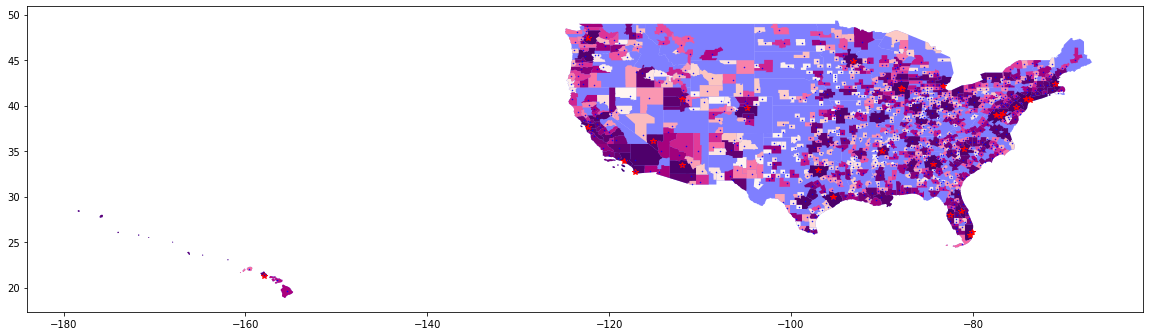

In [126]:
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(111)
us_state.plot(ax=ax, color='b', alpha=0.5)
us_CBSA.plot(column = 'TotPop', cmap='RdPu', ax=ax)
for i in airport_df.index:
    lon = airport_df.loc[i, 'lon']
    lat = airport_df.loc[i, 'lat']
    ax.plot(lon, lat, 'r*')
for i in us_CBSA.index:
    ax.plot(us_CBSA.loc[i, 'INTPTLON'], us_CBSA.loc[i, 'INTPTLAT'], 'b.', markersize=1)

# fig.savefig('./outputs/CBSA_with_airport.png', dpi=1000)

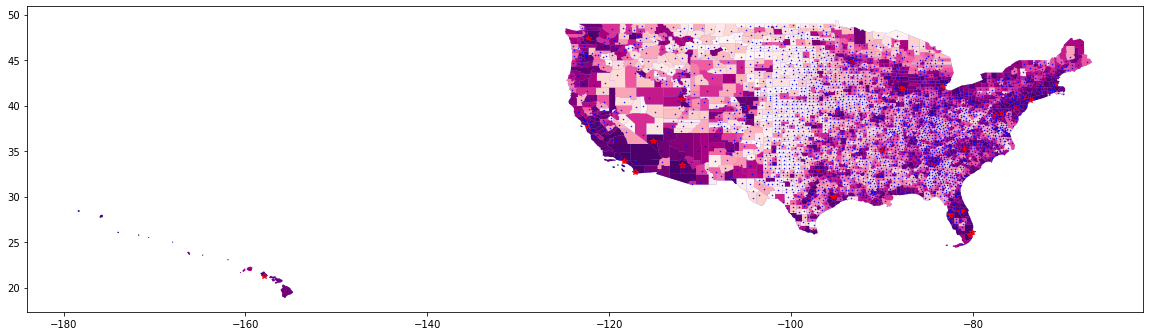

In [128]:
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(111)
us_state.plot(ax=ax, color='b', alpha=0.5)
us_county.plot(column = 'TotPop', cmap='RdPu', ax=ax)
for i in airport_df.index:
    lon = airport_df.loc[i, 'lon']
    lat = airport_df.loc[i, 'lat']
    ax.plot(lon, lat, 'r*')
for i in us_county.index:
    ax.plot(us_county.loc[i, 'INTPTLON'], us_county.loc[i, 'INTPTLAT'], 'b.', markersize=1)

# fig.savefig('./outputs/county_with_airport.png', dpi=1000)

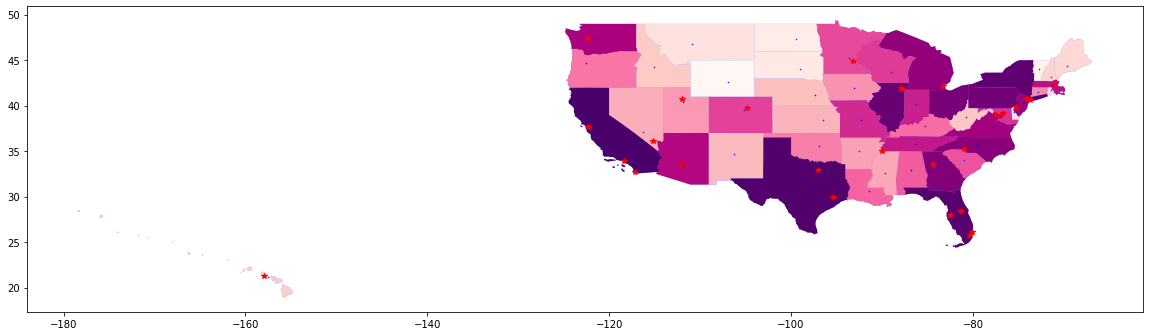

In [129]:
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(111)
us_state.plot(ax=ax, color='b', alpha=0.5)
us_state.plot(column = 'TotPop', cmap='RdPu', ax=ax)
for i in airport_df.index:
    lon = airport_df.loc[i, 'lon']
    lat = airport_df.loc[i, 'lat']
    ax.plot(lon, lat, 'r*')
for i in us_state.index:
    ax.plot(us_state.loc[i, 'INTPTLON'], us_state.loc[i, 'INTPTLAT'], 'b.', markersize=1)

# fig.savefig('./outputs/state_with_airport.png', dpi=1000)

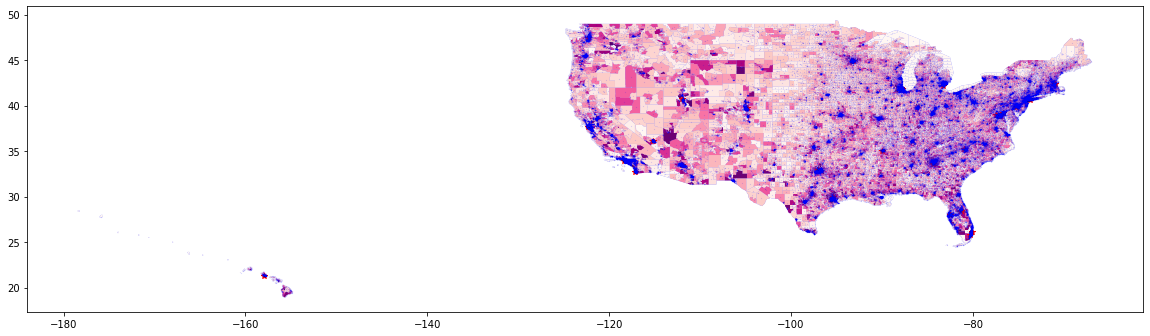

In [132]:
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(111)
us_tract.plot(ax=ax, color='b', alpha=0.5)
us_tract.plot(column = 'TotPop', cmap='RdPu', ax=ax)
for i in airport_df.index:
    lon = airport_df.loc[i, 'lon']
    lat = airport_df.loc[i, 'lat']
    ax.plot(lon, lat, 'r*')
for i in us_tract.index:
    ax.plot(us_tract.loc[i, 'INTPTLON'], us_tract.loc[i, 'INTPTLAT'], 'b.', markersize=.1)

# fig.savefig('./outputs/tract_with_airport.png', dpi=1000)